In [1]:
import pandas as pd
import numpy as np
import time
from utils import dfwellgr,marker_ssig,extract_signature_Xy,plot_simple
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt

random.seed(42)

In [2]:
#Import For Classification 
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

#Import For Testing 
from utils import window, plot_pred_distribution
from utils import get_markers_rocket_order, get_markers_rocket_order_with_constraints
from utils import recall_tops,find_optimal_tolerance

from IPython.display import clear_output
import statistics

### LOAD Data and Testing Data

In [3]:
#Load Prepared Data
X = np.load('prepared_data/X_201.npy')
y = np.load('prepared_data/y_201.npy')

#Load Testing Data
df_test_log = pd.read_parquet('testdata/logs_50.parquet', engine='fastparquet')
df_test_log.loc[df_test_log['GR'] < -1, 'GR' ] = -1
df_test_log.loc[df_test_log['GR'] > 400, 'GR' ] = 400

df_test_loc = pd.read_parquet('testdata/loc_50.parquet', engine='fastparquet')
df_test_loc = df_test_loc.reset_index()

df_test_log = df_test_loc.merge(df_test_log, how = 'inner', left_on = 'wellName', right_on = 'wellName')

df_test_tops = pd.read_csv('testdata/tops_50.csv')
df_test_tops = df_test_tops.set_index('wellName')
cols = ['MARCEL', 'SYLVAIN', 'CONRAD']
df_test_tops = df_test_tops[cols]

### Mini ROCKET

The evolution of ROCKET, MINIROCKET [6], is proposed as the new default variant of ROCKET by its authors and utilizes only one feature per kernel (percentage of positive values), thereby halving the features. It also utilizes other optimizations to speed up ROCKET in general and follows a minimally random approach with a given set of kernels

In [5]:
from sktime.transformations.panel.rocket import MiniRocket

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

minirocket = MiniRocket(num_kernels=10000) 
minirocket.fit(X_train) 

start = time.time()
X_train_transformed = minirocket.transform(X_train) 
et = time.time() - start
print(f'Transforming time for mini ROCKET: {et}')

X_test_transformed = minirocket.transform(X_test) 

Transforming time for mini ROCKET: 1.4239928722381592


In [7]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)


 #XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

(preds == y_test).mean()

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3367, 9996)
 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 1.00000  valid_acc: 1.00000


In [12]:

#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraints(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, minirocket, classifier_xgb, classifier,xgb = False)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 209.07601833343506


In [13]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9933333333333333, mae 3.27
tolerance 15, recall 0.9866666666666667, mae 3.27
tolerance 10, recall 0.9733333333333334, mae 3.27
tolerance 5, recall 0.8266666666666667, mae 3.27
Largest Error MARCEL: 29.0
Largest Error SYLVAIN: 9.0
Largest Error CONRAD: 12.0
Optimal Tolerance : 29


### MultiROCKET

In [4]:
from rocket.multi_rocket.multirocket import MultiRocket

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))


multirocket = MultiRocket(
            num_kernels=1000
        )
    
multirocket.fit(X_train)
start = time.time()
X_train_transformed = multirocket.transform(X_train)
et = time.time() - start
print(f'Transforming time for multi ROCKET: {et}')

X_test_transformed = multirocket.transform(X_test) 

Transforming time for multi ROCKET: 0.5549490451812744


In [12]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)


 #XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

(preds == y_test).mean()

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3367, 7392)
 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 1.00000  valid_acc: 1.00000


In [13]:
#Predict ALL WITH CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraints(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, multirocket, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 52.992242097854614


In [14]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9933333333333333, mae 3.07
tolerance 15, recall 0.9866666666666667, mae 3.07
tolerance 10, recall 0.9666666666666667, mae 3.07
tolerance 5, recall 0.84, mae 3.07
Largest Error MARCEL: 23.0
Largest Error SYLVAIN: 14.0
Largest Error CONRAD: 18.0
Optimal Tolerance : 23


### LightWaveS

In [15]:
from rocket.lightwaves.lightwavesl1l2_functions import _generate_first_phase_kernels, _apply_2layer_kernels
from rocket.lightwaves.lightwaves_utils import ScalePerChannel, anova_feature_selection, mrmr_feature_selection, ScalePerChannelTrain, \
    ckd_to_kernels, get_fixed_candidate_kernels, get_ckd_matrix_with_features

from rocket.lightwaves.lightwaves import LightWaveS

In [67]:
X = np.load('prepared_data/X_201.npy').astype(np.float32)
y = np.load('prepared_data/y_201.npy')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lightwaves = LightWaveS(final_num_feat=1000)
lightwaves.fit(X_train,y_train)

start = time.time()
X_train_transformed = lightwaves.transform(X_train)
et = time.time() - start
print(f'Transforming time for mini ROCKET: {et}')

X_test_transformed = lightwaves.transform(X_test) 


Transforming time for mini ROCKET: 0.7791740894317627


In [68]:
#Ridge
classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
classifier.fit(X_train_transformed, y_train)

classifier.score(X_test_transformed, y_test)


 #XGBoost classifier
eps = 1e-6

# normalize 'per feature'
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps
X_train_norm = (X_train_transformed - f_mean) / f_std
X_valid_norm = (X_test_transformed - f_mean) / f_std
print(X_train_norm.shape)

classifier_xgb = xgb.XGBClassifier(max_depth=5, n_estimators=100,n_jobs=-1)
classifier_xgb.fit(X_train_norm, y_train)
preds = classifier_xgb.predict(X_valid_norm)

(preds == y_test).mean()

##logistic regression

eps = 1e-6
C = 1e-2
f_mean = X_train_transformed.mean(axis=0)
f_std = X_train_transformed.std(axis=0) + eps  # epsilon to avoid dividing by 0
X_train_tfm2 = (X_train_transformed - f_mean) / f_std
X_valid_tfm2 = (X_test_transformed - f_mean) / f_std
classifier = LogisticRegression(penalty='l2', C=C, n_jobs=-1)
classifier.fit(X_train_tfm2, y_train)
probas = classifier.predict_proba(X_train_tfm2)
train_score = classifier.score(X_train_tfm2, y_train)
val_score = classifier.score(X_valid_tfm2, y_test)
print('{:2} eps: {:.2E}  C: {:.2E}   train_acc: {:.5f}  valid_acc: {:.5f}'.format(1, eps, C, train_score, val_score))

(3367, 1000)
 1 eps: 1.00E-06  C: 1.00E-02   train_acc: 0.99851  valid_acc: 0.99644


Prediction:[6462, 6579, 6624]
Real:[6460.0, 6592.0, 6620.0]


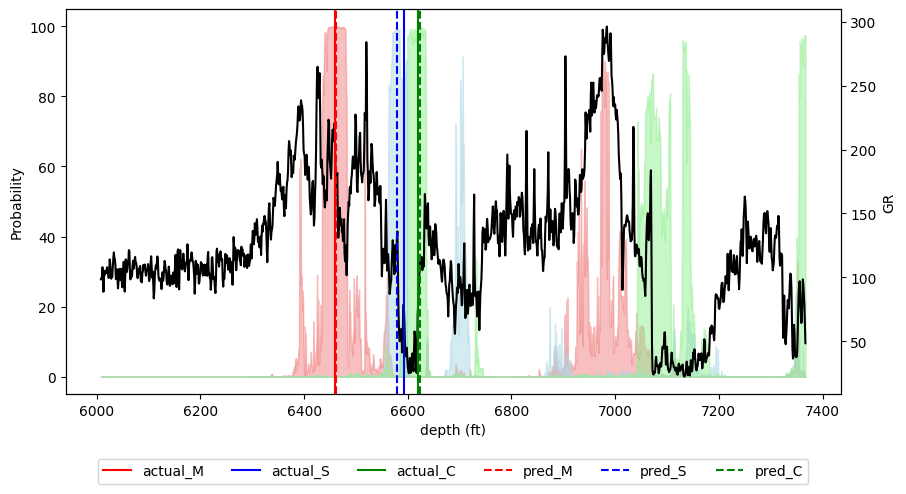

In [69]:
# Example Testing with one well before start process prediciton on the entire testing dataset

wsize = 201 #adjust as needed
well = 512322535
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']

#Predict Marker Depth without Constraint 
pred_m, df_wm = get_markers_rocket_order_with_constraints(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, lightwaves, classifier_xgb, classifier,xgb = True)

td  = list(df_test_tops.loc[[well][0]]) 
print(f'Prediction:{pred_m}')
print(f'Real:{td}')
plot_pred_distribution(td, pred_m, df_wm)

In [70]:
#Predict ALL WITH CONSTRAINTS
#create the predicted_tops for all well, by looping trough the list
start = time.time()
wsize = 201
input_variable=['GR']
pred_column = ['None','Marcel', 'Sylvian', 'Conrad']
df_tops_pred = pd.DataFrame(pd.DataFrame(columns = ['wellName','MARCEL', 'SYLVAIN', 'CONRAD']))

for well in df_test_tops.index:
    print(well)
    pred_m, df_wm = get_markers_rocket_order_with_constraints(f_mean, f_std, df_test_log, well, pred_column, wsize, input_variable, lightwaves, classifier_xgb, classifier,xgb = True)
    print(pred_m)
    row = {'wellName':well, 'MARCEL':pred_m[0], 'SYLVAIN':pred_m[1], 'CONRAD':pred_m[2]}
    row_df = pd.DataFrame([row])
    df_tops_pred = pd.concat([df_tops_pred, row_df], axis = 0, ignore_index = "True")

clear_output()
ext = time.time() - start
print('Total time take',ext)
df_tops_pred['wellName']  = df_tops_pred['wellName'].astype(float)
df_tops_pred = df_tops_pred.sort_values(by = ['wellName']).reset_index().drop(['index'], axis = 1)
df_tops_pred = df_tops_pred.set_index('wellName')
#df_tops_pred.head()

Total time take 77.90778303146362


In [71]:
#call the evaluate function
tr = [20, 15, 10, 5]
for tolerance in tr:
#recall is percentage of positive values that is correclty identified,
# so true positive/ sum of num_all positive
    recall, mae, df_result = recall_tops(df_test_tops,df_tops_pred,tolerance)
    print("tolerance {0}, recall {1}, mae {2}".format(tolerance, recall, mae))

optimal_tolerance = find_optimal_tolerance(df_test_tops, df_tops_pred)
print(f"Largest Error MARCEL: {df_result['MARCEL_ae'].max()}")
print(f"Largest Error SYLVAIN: {df_result['SYLVAIN_ae'].max()}")
print(f"Largest Error CONRAD: {df_result['CONRAD_ae'].max()}")
print("Optimal Tolerance :", optimal_tolerance)

tolerance 20, recall 0.9933333333333333, mae 3.256666666666667
tolerance 15, recall 0.9866666666666667, mae 3.256666666666667
tolerance 10, recall 0.9533333333333334, mae 3.256666666666667
tolerance 5, recall 0.8266666666666667, mae 3.256666666666667
Largest Error MARCEL: 26.0
Largest Error SYLVAIN: 18.0
Largest Error CONRAD: 14.0
Optimal Tolerance : 26
